# PDEfind Usage Examples

We discuss how to use the PDEfind library on specific examples. 

## Diffusion equation

Consider the equation 
$$\partial_t u(t,x) = \partial_x^2 u(t,x)$$
on $(t, x) \in [0,1] \times [0,1]$ with Dirichlet boundary conditions.

First, prepare the mock data.

In [1]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dxx = Differential(x)^2

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ Dxx(u(t, x))
bcs = [u(0, x) ~ (sin(pi*x) + 0.5* sin(3*pi*x)),
        u(t, 0) ~ 0.0,
        u(t, 1) ~ 0.0]

# Space and time domains
domains = [t ∈ Interval(0.0, 0.3),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (301, 501) sized solution
  Domain:
    t ∈ (0.0, 0.3) with 301 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


L"\begin{align}
 - \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) =& 0
\end{align}
"

L"\begin{align}
u\left( 0, x \right) =& 0.5 \sin\left( 9.4248 x \right) + \sin\left( \pi x \right) \\
u\left( t, 0 \right) =& 0 \\
u\left( t, 1 \right) =& 0
\end{align}
"

Import the package

In [2]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [3]:
# start with given data
time_range = 0.0:0.002:0.3
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.282, 0.284, 0.286, 0.288, 0.29, 0.292, 0.294, 0.296, 0.298, 0.3], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 151, 251, 37901, [0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3; … ; 0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

Note: `normalization_factors` are an irrelevant trick used for stability of the algorithm.

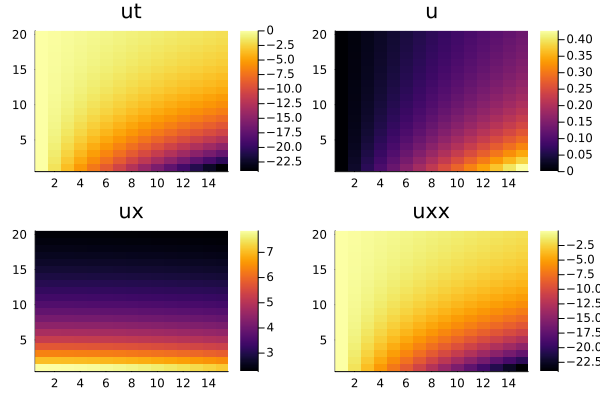

In [16]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4) # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[1:20,1:15], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[1:20,1:15], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[1:20,1:15], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[1:20,1:15], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [17]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

37901×15 Matrix{Float64}:
 1.0  0.0   7.85398   -0.000757667  -448.551    …   0.339853        2.01198e5
 1.0  0.0   7.02595   -0.000636416  -380.131        0.241922        1.445e5
 1.0  0.0   6.32436   -0.000535209  -322.741        0.172734        1.04162e5
 1.0  0.0   5.7262    -0.000446703  -274.247        0.122507    75211.5
 1.0  0.0   5.21783   -0.000374934  -233.797        0.0876585   54661.1
 1.0  0.0   4.78562   -0.000314778  -199.869    …   0.0629145   39947.6
 1.0  0.0   4.41413   -0.000264353  -171.357        0.0452988   29363.3
 1.0  0.0   4.09407   -0.000222128  -147.384        0.0327381   21722.1
 1.0  0.0   3.82046   -0.00018675   -127.281        0.0237696   16200.4
 1.0  0.0   3.58383   -0.000157123  -110.38         0.0173431   12183.7
 ⋮                                              ⋱               
 1.0  0.0  -0.190505  -3.789e-7        1.87969     -7.12214e-7      3.53323
 1.0  0.0  -0.186707  -3.71347e-7      1.84222     -6.84101e-7      3.39376
 1.0  0.0  -0.183105 

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [18]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-3, tol = 1.0, iters = 4, verbose = true, normalize_columns = true)

Iteration: 4, threshold: 1.0. 
Iteration: 3, threshold: 1.0. 
Iteration: 2, threshold: 1.0. 
Iteration: 1, threshold: 1.0. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \textcolor{grey}{\xi_{1000}u} + \textcolor{grey}{\xi_{0100}\partial_{x} u} + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \textcolor{grey}{\xi_{1100}u\partial_{x} u} + \xi_{1010}u\partial_{xx} u + \textcolor{grey}{\xi_{1001}u\partial_{xxx} u} + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{\xi_{0101}\partial_{x} u\partial_{xxx} u} + \xi_{0020}(\partial_{xx} u)^2 + \xi_{0011}\partial_{xx} u\partial_{xxx} u + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = 0.01 \\ }\textcolor{grey}{\xi_{1000} = -0.03 \\ }\textcolor{grey}{\xi_{0100} = -0.0 \\ }\xi_{0010} = 22.62 \\ \textcolor{grey}{\xi_{0001} = -0.07 \\ }\textcolor{grey}{\xi_{2000} = 0.03 \\ }\textcolor{grey}{\xi_{1100} = 0.0 \\ }\xi_{1010} = 1.51 \\ \textcolor{grey}{\xi_{1001} = 0.07 \\ }\textcolor{grey}{\xi_{0200} = -0.24 \\ }\textcolor{grey}{\xi_{0110} = 0.07 \\ }\textcolor{grey}{\xi_{0101} = 0.28 \\ }\xi_{0020} = 11.03 \\ \xi_{0011} = 2.28 \\ \xi_{0002} = 278.97 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \xi_{0020}(\partial_{xx} u)^2 + \textcolor{grey}{\xi_{0011}\partial_{xx} u\partial_{xxx} u} + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\xi_{0010} = 24.08 \\ \textcolor{grey}{\xi_{1010} = 0.2 \\ }\xi_{0020} = 1.54 \\ \textcolor{grey}{\xi_{0011} = 0.61 \\ }\xi_{0002} = -37.98 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0020}(\partial_{xx} u)^2} + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\xi_{0010} = 24.25 \\ \textcolor{grey}{\xi_{0020} = -1.0 \\ }\xi_{0002} = -9.6 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\xi_{0010} = 24.27 \\ \xi_{0002} = -19.85 \\ $ 
 - - -

([24.273974260184797, -19.854951730598753], Any[[0, 0, 1, 0], [0, 0, 0, 2]])

The threshold landscape exploration. 

In [19]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-6:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-3, tol=tol, iters=5, verbose=false)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

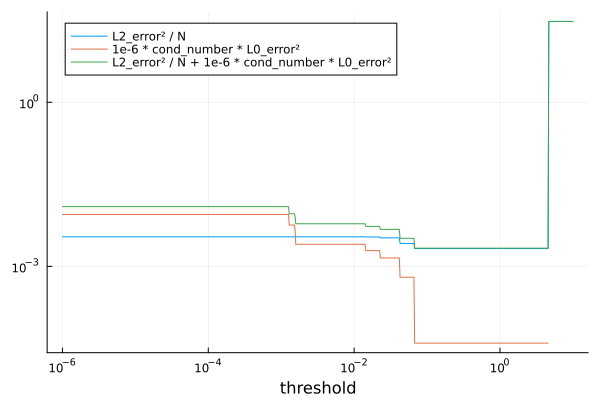

In [20]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-6 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-6 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-6 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-6 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [21]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-3, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 40)

Split input data to 30321 train and 7580 test samples. 
Using η = 1.0e-6 * 39.58158690023327. 
Initialization: [-0.003652766842049083, -0.2731629003034137, 0.04285476228812328, 4.015613227903716, 0.005386915519471803, 0.28970834037350285, -0.020806155437848868, 0.6967213995519683, 0.003769832147966404, -0.13740907651532852, 0.05432154787166472, -0.10653326540431163, 0.15326767109127806, 0.015928868899847067, -0.03304665967492855]
Initialization: tol = 6.852183389825418
0
tol_iter = 1: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [4.7707714943731]. Decreased Threshold to 3.426091694912709. 
tol_iter = 2: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [4.7707714943731]. Decreased Threshold to 1.142030564970903. 
tol_iter = 3: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [4.7707714943731]. Decreased Threshold to 0.22840611299418062. 
tol_iter = 4: Stepsize too big. Decreased tol_multiplier to 4.0. 
tol_iter = 5: Stepsize too big. Decr

([4.7707714943731], Any[[0, 0, 1, 0]])

Investigate behaviour at different $\lambda$.

Initialization: [0.001581819280028457, -0.006334846219525087, -0.0013965890991458998, 4.6203999291890065, 0.0013125203216533155, 0.007111276831178916, 0.003951115553035444, 0.004759787324989534, 2.7563581408899876e-5, 0.00132222512026361, 0.0027266085841612334, 0.0006431426406276453, -0.00137107380028599, 0.0024464857915953756, -0.00028446791845600987]
Initialization: tol = 5.655669451255361
0
Initialization: [0.0015818192799948619, -0.006334846229018872, -0.0013965890974691432, 4.6203999291676725, 0.001312520322615273, 0.007111276841415818, 0.003951115552083532, 0.004759787348863293, 2.7563580763538565e-5, 0.0013222251153961553, 0.0027266085860282955, 0.0006431426361810877, -0.0013710737949361596, 0.0024464857919771175, -0.00028446792010021504]
Initialization: tol = 5.655669451264518
0
Initialization: [0.0015818192798909573, -0.006334846259556683, -0.0013965890921009963, 4.620399929101429, 0.0013125203255612678, 0.007111276874075635, 0.003951115549077314, 0.004759787424658697, 2.75635

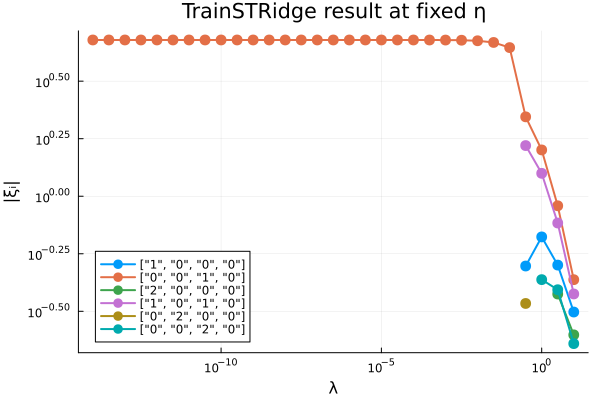

In [22]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)

## Advective diffusion 
Repeat the above for 
$$\partial_t u(t,x) = - 6 u(t,x) \partial_x u(t,x) + \partial_{xx} u(t,x),$$
on 

In [62]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
Dxxx = Differential(x)^3

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ - 6 * u(t,x) * Dx(u(t, x)) + Dxx(u(t,x))
bcs = [u(0, x) ~ (exp(- (x-0.5)^2 / (2 * 0.1^2))),
        u(t, 0) ~ u(t, 1)
        ]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines /home/natan/.julia/packages/MethodOfLines/glDxX/src/system_parsing/pde_system_transformation.jl:42


L"\begin{align}
 - \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) + 6 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) u\left( t, x \right) =& 0
\end{align}
"

L"\begin{align}
u\left( 0, x \right) =& e^{ - 50 \left( -0.5 + x \right)^{2}} \\
u\left( t, 0 \right) =& u\left( t, 1 \right)
\end{align}
"

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (1001, 501) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 1001 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


In [63]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [64]:
# start with given data
time_range = 0.0:0.002:1.0
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.982, 0.984, 0.986, 0.988, 0.99, 0.992, 0.994, 0.996, 0.998, 1.0], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 501, 251, 125751, [0.0 0.002 … 0.998 1.0; 0.0 0.002 … 0.998 1.0; … ; 0.0 0.002 … 0.998 1.0; 0.0 0.002 … 0.998 1.0], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

Note: `normalization_factors` are an irrelevant trick used for stability of the algorithm.

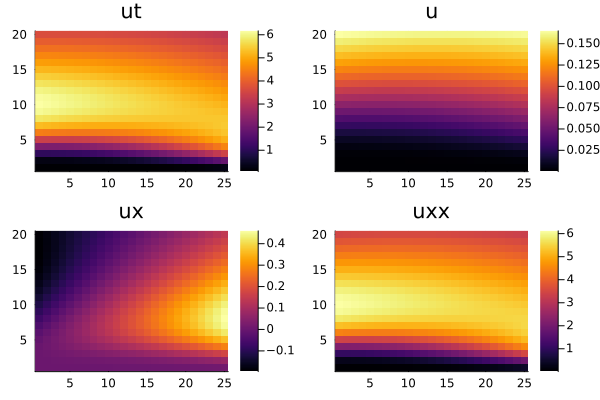

In [69]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4, boundary_condition="neumann") # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
# a,b = 1:size(data_array, 1),1:size(data_array, 2)
a,b = 1:20,1:25
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[a,b], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[a,b], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[a,b], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[a,b], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [70]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

125751×15 Matrix{Float64}:
 1.0  3.72665e-6    0.000186285  …    0.00394137     0.195436
 1.0  0.000223395  -7.80899e-6        0.00687108     0.000647615
 1.0  0.00143751   -0.000445533      -0.605238       0.345328
 1.0  0.00460258   -0.00355462       -5.95352        7.51116
 1.0  0.0101735    -0.0122684       -19.8384        34.3296
 1.0  0.0180431    -0.0274639    …  -38.242         74.1461
 1.0  0.0277791    -0.0477787       -53.3668       103.862
 1.0  0.0388441    -0.0708812       -60.3286       109.756
 1.0  0.0507252    -0.094509        -58.668         94.4126
 1.0  0.0629898    -0.116932        -50.6172        68.3736
 ⋮                               ⋱                 
 1.0  0.249829      2.84217e-14       2.46718e-18    2.14785e-15
 1.0  0.249764      0.0              -1.81391e-19    3.1538e-16
 1.0  0.249752     -5.68434e-14       5.581e-18      4.14288e-15
 1.0  0.249812      1.42109e-13  …    1.26087e-17    2.48688e-14
 1.0  0.249864      2.84217e-14       1.24935e-17    1

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [71]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol = 1.0, iters = 4, verbose = true, normalize_columns = true)

Iteration: 4, threshold: 1.0. 
Iteration: 3, threshold: 1.0. 
Iteration: 2, threshold: 1.0. 
Iteration: 1, threshold: 1.0. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \textcolor{grey}{\xi_{1000}u} + \textcolor{grey}{\xi_{0100}\partial_{x} u} + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \textcolor{grey}{\xi_{1100}u\partial_{x} u} + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \xi_{1001}u\partial_{xxx} u + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \xi_{0101}\partial_{x} u\partial_{xxx} u + \xi_{0020}(\partial_{xx} u)^2 + \xi_{0011}\partial_{xx} u\partial_{xxx} u + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = -0.08 \\ }\textcolor{grey}{\xi_{1000} = 0.0 \\ }\textcolor{grey}{\xi_{0100} = 0.01 \\ }\xi_{0010} = 6.02 \\ \textcolor{grey}{\xi_{0001} = 0.38 \\ }\textcolor{grey}{\xi_{2000} = -0.0 \\ }\textcolor{grey}{\xi_{1100} = -0.09 \\ }\textcolor{grey}{\xi_{1010} = -0.28 \\ }\xi_{1001} = -1.41 \\ \textcolor{grey}{\xi_{0200} = 0.07 \\ }\textcolor{grey}{\xi_{0110} = -0.2 \\ }\xi_{0101} = 16.41 \\ \xi_{0020} = -10.74 \\ \xi_{0011} = 22.31 \\ \xi_{0002} = 959.33 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1001}u\partial_{xxx} u + \xi_{0101}\partial_{x} u\partial_{xxx} u + \xi_{0020}(\partial_{xx} u)^2 + \xi_{0011}\partial_{xx} u\partial_{xxx} u + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\xi_{0010} = 5.91 \\ \xi_{1001} = 17.43 \\ \xi_{0101} = 8.77 \\ \xi_{0020} = 2.55 \\ \xi_{0011} = 366.8 \\ \xi_{0002} = 875.3 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1001}u\partial_{xxx} u + \xi_{0101}\partial_{x} u\partial_{xxx} u + \xi_{0020}(\partial_{xx} u)^2 + \xi_{0011}\partial_{xx} u\partial_{xxx} u + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\xi_{0010} = 5.91 \\ \xi_{1001} = 17.43 \\ \xi_{0101} = 8.77 \\ \xi_{0020} = 2.55 \\ \xi_{0011} = 366.8 \\ \xi_{0002} = 875.3 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1001}u\partial_{xxx} u + \xi_{0101}\partial_{x} u\partial_{xxx} u + \xi_{0020}(\partial_{xx} u)^2 + \xi_{0011}\partial_{xx} u\partial_{xxx} u + \xi_{0002}(\partial_{xxx} u)^2 \\ $ with: $ \\\xi_{0010} = 5.91 \\ \xi_{1001} = 17.43 \\ \xi_{0101} = 8.77 \\ \xi_{0020} = 2.55 \\ \xi_{0011} = 366.8 \\ \xi_{0002} = 875.3 \\ $ 
 - - -

([5.914970889901794, 17.43225660455506, 8.77387463251695, 2.5461327698691343, 366.7987509032517, 875.300961861996], Any[[0, 0, 1, 0], [1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 2, 0], [0, 0, 1, 1], [0, 0, 0, 2]])

The threshold landscape exploration. 

In [72]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-6:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-3, tol=tol, iters=5, verbose=false)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

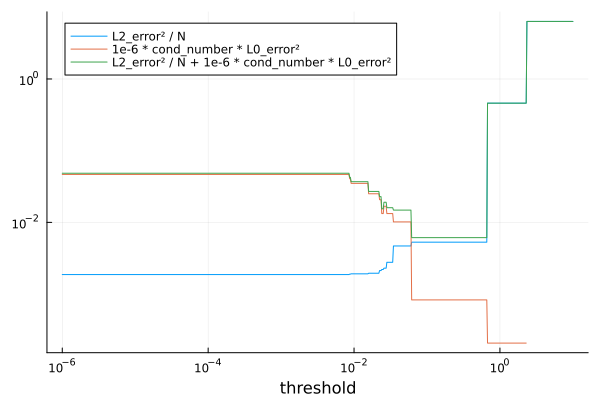

In [73]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-6 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-6 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-6 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-6 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [74]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-3, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 40)

Split input data to 100601 train and 25150 test samples. 
Using η = 1.0e-6 * 207.2354532916494. 
Initialization: [0.23727879534888846, 0.0010052939608111823, 0.012198107358136916, 2.7793818661111924, 0.019782407033380207, -0.12277605006898766, -0.8961115077742189, -0.027289366451800332, -0.0451083816746926, 0.19802028399608756, -0.03497901253100714, 0.2906921551739196, -0.03678882941379154, 0.030864108524804236, 0.11870606751186198]
Initialization: tol = 5.850982232933581
0
tol_iter = 1: Found better/equal fit with polynomials Any[], xi = Float64[]. Decreased Threshold to 2.9254911164667905. 
tol_iter = 2: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [2.6448143744156742]. Decreased Threshold to 0.9751637054889302. 
tol_iter = 3: Found better/equal fit with polynomials Any[[0, 0, 1, 0], [1, 1, 0, 0]], xi = [2.665815505884128, -0.7498375884929013]. Decreased Threshold to 0.19503274109778604. 
tol_iter = 4: Stepsize too big. Decreased tol_multiplier to 4.0. 
tol_iter = 

([2.665815505884128, -0.7498375884929013], Any[[0, 0, 1, 0], [1, 1, 0, 0]])

Investigate behaviour at different $\lambda$.

Initialization: [-0.13704745272871705, 0.06279161365784998, 0.04864517363649501, 2.975333292551509, 0.017786907802425565, -0.1420483734290011, -0.967493094924436, -0.2365327250800496, -0.08642684411034801, 0.09714768344395201, -0.04077720603792821, 0.1314313888686495, -0.10738153986559601, 0.020472692999390286, 0.03295203221865052]
Initialization: tol = 6.104268021354998
0
Initialization: [-0.1370474527114146, 0.06279161365480139, 0.04864517363534387, 2.975333292543648, 0.01778690780221434, -0.14204837342734986, -0.9674930949223285, -0.23653272507156445, -0.08642684410886076, 0.09714768344796355, -0.04077720603770676, 0.13143138887505418, -0.10738153986285602, 0.020472692999819384, 0.03295203222213997]
Initialization: tol = 6.104268021323065
0
Initialization: [-0.13704745265660043, 0.06279161364491599, 0.04864517363169694, 2.975333292519158, 0.017786907801514505, -0.14204837342199064, -0.9674930949155881, -0.236532725044413, -0.08642684410405478, 0.09714768346056091, -0.040777206037016

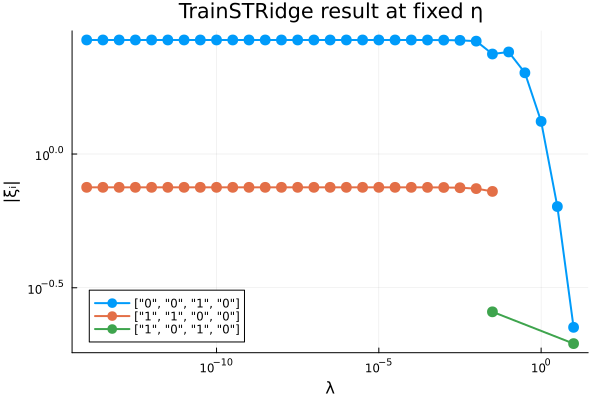

In [75]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)

In [ ]:
# tests for noise!
using NoiseRobustDifferentiation
# start with given data
time_range = 0.0:0.001:0.1
space_range = 0.0:0.01:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)
# prepare LHS

dt_data_array = copy(data_array)
for i in 1:g.nx
    dt_data_array[:,i] = tvdiff(data_array[:,i], 1, 1e-9; dx=g.dt, scale="small", precond="none")
end

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
max_derivative_degree = 3
variables_matrix = [data_array]
current_array = copy(data_array)
for j in 1:g.nt
    current_array[j, :] = tvdiff(current_array[j, :], 100, 1e-5, dx=g.dx)            
end
push!(variables_matrix, current_array)
current_array2 = copy(current_array)
for j in 1:g.nt
    current_array2[j, :] = tvdiff(current_array2[j, :], 100, 1e-5, dx=g.dx)            
end
push!(variables_matrix, current_array2)
using Plots
p1 = heatmap(dt_data_array[1:20,1:15], title="ut")
p2 = heatmap(variables_matrix[1][1:20,1:15], title="u")
p3 = heatmap(variables_matrix[2][1:20,1:15], title="ux")
p4 = heatmap(variables_matrix[3][1:20,1:15], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))


In [ ]:
# comparison for heat analytic
true_sol = zero(data_array)
dt_true_sol = zero(data_array)
d1_true_sol = zero(data_array)
d2_true_sol = zero(data_array)
for (i,t) in enumerate(time_range), (j,x) in enumerate(space_range)
    true_sol[i,j] = exp(- pi^2 * t) * sin(pi*x) + 0.5 * exp(- 3.0^2 * pi^2 * t) * sin(3.0*pi*x) 
    dt_true_sol[i,j] = - pi^2 * exp(- pi^2 * t) * sin(pi*x) - 3.0^2 * 0.5 * pi^2 * exp(- 3.0^2 * pi^2 * t) * sin(3.0*pi*x) 
    d1_true_sol[i,j] = pi * exp(- pi^2 * t) * cos(pi*x) + 1.5 * pi * exp(- 3.0^2 * pi^2 * t) * cos(3.0*pi*x)
    d2_true_sol[i,j] = - pi^2 * exp(- pi^2 * t) * sin(pi*x) - 3.0^2 * 0.5 * pi^2 * exp(- 3.0^2 * pi^2 * t) * sin(3.0*pi*x) 
end
time_range = 0.0:0.001:0.1
space_range = 0.0:0.02:1.0
data_array = true_sol#sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; degree=1, order=4) # takes BC and order as arguments
∂x² = XDerivative(g; degree=2, order=2) # takes BC and order as arguments
d1_data_array = ∂x(data_array)
d2_data_array = ∂x(∂x(data_array))
# d2_data_array = ∂x²(data_array)

variables_matrix = [reshape(data_array, g.N),reshape(d1_data_array, g.N),reshape(d2_data_array, g.N)] 

using Plots
p1 = heatmap(((dt_data_array - dt_true_sol)/dt_true_sol)[1:20,1:15], title="ut")
p2 = heatmap((data_array    -    true_sol)[1:20,1:15], title="u")
p3 = heatmap(((d1_data_array - d1_true_sol)/d1_true_sol)[1:20,1:15], title="ux")
p4 = heatmap(((d2_data_array - d2_true_sol)/d2_true_sol)[1:20,1:15], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [ ]:
# proof that my norm is better
using LinearAlgebra
a, b, c, d = [], [], [], []
for dx in 0.002.*collect(1:1:10), dt in 0.001.*collect(1:1:20)
    # dt = 0.001
    # start with given data
    time_range = 0.0:dt:0.3
    space_range = 0.0:dx:1.0
    data_array = sol(time_range, space_range)[1]
    time_array = collect(time_range)
    space_array= collect(space_range)
    time_len= length(time_array)
    space_len= length(space_array)


    # initialize grid
    g = TimeSpaceGrid1D(time_array, space_array)
    # prepare LHS
    # make finite difference operator
    ∂t = TimeDerivative(g) # takes BC and order as arguments
    dt_data_array = ∂t(data_array) 
    dt_data_array_flat = reshape(dt_data_array, g.N) 

    # prepare RHS
    # construct relevant variables from highest order spatial derivative to consider
    ∂x = XDerivative(g; order=2) # takes BC and order as arguments
    max_derivative_degree = 2
    variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

    # construct basis functions, eg: polynomial basis
    max_poly_degree = 2
    n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
    MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

    # theta matrix
    Θ = evaluate(MyBasis, variables_matrix)
    cond_number = cond(Θ, 2) #norm(Θ, 2) * norm(pinv(Θ),2)

    xi,_ = STRidge_cascade(Θ, dt_data_array_flat, MyBasis, λ = 1e2, tol = 0.0, iters = 1, verbose = false, normalize_columns = true)

    push!(a, time_len)
    push!(b, space_len)
    push!(c, cond_number)
    push!(d, norm(Θ * xi - dt_data_array_flat, 2)^2)
   
end

using Plots
N = a.*b
scatter(N, d .*1e3 ./N ./ c, xscale=:log10, yscale=:log10, label="Rudy et. al. norm", xlabel="N", ylabel="2-error / condition number multiplier")
scatter!(N, d .*1e6 ./N ./ c.^2, xscale=:log10, yscale=:log10, label="Modified norm")

In [ ]:
# investigate behaviour at different $\eta$.
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5, cond_number_multiplier=1e-9)
p1 = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="η = 1e-9")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end

to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5, cond_number_multiplier=1e-6)
p2 = plot(legend=:bottomleft, xlabel="λ", title="η = 1e-6")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end

to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5, cond_number_multiplier=1e-3)
p3 = plot(legend=:bottomleft, xlabel="λ", title="η = 1e-3")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end

plot(p1, p2, p3, layout = (1,3), sharey=true)